In [36]:
import requests
import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
df0 = pd.read_fwf('PCC_cat.txt', header=None)
# df0
# df0[21]

# Here we have 7 unique labels:

In [3]:
print(np.unique(df0[21]))
print(len(np.unique(df0[21]))) # number of unique labels

['Cluster or background LTG' 'Likely background ETG or unresolved source'
 'Likely cluster or background edge-on disk galaxy'
 'Likely dE/ETGcluster candidate' 'Likely merging system'
 'Possible dE/ETGcluster candidate'
 'background galaxy with possibly weak substructure']
7


In [4]:
# access ra and dec from their columns in the datagframe
ra = df0[2]
dec = df0[3]
workDir = 'SDSS2'

# df1 = pd.DataFrame()
filenames = []
for r, d in zip(ra, dec):
    fn = f'sdss_ra={r}_dec={d}.jpeg'
    filenames.append(fn)

# # turning labels to numbers -- didn't use this method - verify? -- TODO
le = LabelEncoder()
labelToNum = le.fit_transform(df0[21])

df1 = pd.DataFrame({'files' : filenames,
                    'labels': df0[21]})    

print(df1) 
# splitting dataframe by row index
ind = int(5437*.80) # split data 80/20 -- Need to split randomly: Look into helper funcs for train/test split
trainDf = df1.iloc[:ind,:]
testDf = df1.iloc[ind:,:]


                                 files  \
0     sdss_ra=49.2355_dec=41.5722.jpeg   
1     sdss_ra=49.2366_dec=41.4013.jpeg   
2      sdss_ra=49.237_dec=41.4336.jpeg   
3     sdss_ra=49.2377_dec=41.5285.jpeg   
4      sdss_ra=49.238_dec=41.4346.jpeg   
...                                ...   
5432   sdss_ra=50.0062_dec=41.238.jpeg   
5433  sdss_ra=50.0064_dec=41.2568.jpeg   
5434  sdss_ra=50.0068_dec=41.6048.jpeg   
5435   sdss_ra=50.007_dec=41.3916.jpeg   
5436  sdss_ra=50.0089_dec=41.6781.jpeg   

                                                labels  
0     Likely cluster or background edge-on disk galaxy  
1     Likely cluster or background edge-on disk galaxy  
2     Likely cluster or background edge-on disk galaxy  
3           Likely background ETG or unresolved source  
4     Likely cluster or background edge-on disk galaxy  
...                                                ...  
5432        Likely background ETG or unresolved source  
5433  Likely cluster or background edge

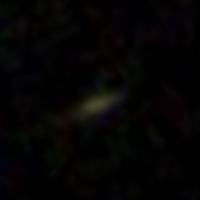

In [5]:
from keras.preprocessing.image import load_img

load_img('SDSS1/sdss_ra=49.2355_dec=41.5722.jpeg')

In [6]:
trainDf

,files,labels
0,sdss_ra=49.2355_dec=41.5722.jpeg,Likely cluster or background edge-on disk galaxy
1,sdss_ra=49.2366_dec=41.4013.jpeg,Likely cluster or background edge-on disk galaxy
2,sdss_ra=49.237_dec=41.4336.jpeg,Likely cluster or background edge-on disk galaxy
3,sdss_ra=49.2377_dec=41.5285.jpeg,Likely background ETG or unresolved source
4,sdss_ra=49.238_dec=41.4346.jpeg,Likely cluster or background edge-on disk galaxy
...,...,...
4344,sdss_ra=49.8648_dec=41.5081.jpeg,Likely cluster or background edge-on disk galaxy
4345,sdss_ra=49.8649_dec=41.3532.jpeg,Likely dE/ETGcluster candidate
4346,sdss_ra=49.8649_dec=41.2249.jpeg,Cluster or background LTG
4347,sdss_ra=49.8654_dec=41.4619.jpeg,Likely background ETG or unresolved source


In [7]:
x = df1['labels']
x = x.tolist()

# Balance of data
for i in range(7):
    print(x.count(i)/5437)

print(le.classes_)
print(le.transform(le.classes_))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
['Cluster or background LTG' 'Likely background ETG or unresolved source'
 'Likely cluster or background edge-on disk galaxy'
 'Likely dE/ETGcluster candidate' 'Likely merging system'
 'Possible dE/ETGcluster candidate'
 'background galaxy with possibly weak substructure']
[0 1 2 3 4 5 6]


In [8]:


datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.33)
# datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
dataframe=trainDf,
directory="./SDSS1/",
x_col="files",
y_col="labels",
subset="training",
batch_size=1, # divisibility 
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(200,200))

valid_generator=datagen.flow_from_dataframe(
dataframe=trainDf,
directory="./SDSS1/",
x_col="files",
y_col="labels",
subset="validation",
batch_size=1,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(200, 200))

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=testDf,
directory="./SDSS1/",
x_col="files",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(200,200))

Found 2914 validated image filenames belonging to 7 classes.
Found 1435 validated image filenames belonging to 7 classes.
Found 1088 validated image filenames.


In [9]:
# Model from online example with image classification of animals
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(200,200,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax')) # always want last layer to output same number of categories
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 200, 200, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 198, 198, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 99, 99, 64)        1

In [10]:
# Me trying to implement CNN from paper
# model = Sequential()
# model.add(Conv2D(32, (3, 3), padding='same',
#                  input_shape=(200,200,3)))
# model.add(Dense(7, activation='softmax')) # always want last layer to output same number of categories
# model.add(Dense(3))
# model.add(Activation('relu'))
# model.add(Dense(24))

# model.add(MaxPooling2D(pool_size=(3, 3)))
# model.add(Activation('relu'))
# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Dense(7, activation='softmax')) # always want last layer to output same number of categories


# model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()


In [11]:
# '''Oxford’s Visual Geometry Group. VGG6 is a very 
# simple network that performs well in traditional 
# image classification competitions 
# (e.g. those using the ImageNet data)'''

# def vgg6(input_shape=(21, 21, 1), n_classes: int = 2):
#     """
#         VGG6
#     :param input_shape:
#     :param n_classes:
#     :return:
#     """

#     model = tf.keras.models.Sequential(name='VGG6')
#     # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
#     # this applies 16 convolution filters of size 3x3 each.
#     model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
#     model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
#     model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#     model.add(tf.keras.layers.Dropout(0.25))

#     model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
#     model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
#     model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
#     model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
#     model.add(tf.keras.layers.Dropout(0.25))

#     model.add(tf.keras.layers.Flatten())

#     model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
#     model.add(tf.keras.layers.Dropout(0.5))
#     # output layer
#     activation = 'sigmoid' if n_classes == 1 else 'softmax'
#     model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

#     return model


In [12]:
# vgg_model = vgg6()
# vgg_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
# n_epochs=15
# vgg_model.summary()


In [13]:
# vgg_model_history = vgg_model.fit(data_train, class_train, epochs=n_epochs, batch_size=1024, verbose=2, 
#                                   validation_data=(data_val, class_val), shuffle=True)
# classes = vgg_model.predict(data_test)

# vgg_model_history = vgg_model.fit(train_generator, epochs = 5, verbose = 2, validation_data = valid_generator, shuffle = True)
# STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
# vgg_model_history = vgg_model.fit_generator(generator=train_generator,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=valid_generator,
#                     validation_steps=STEP_SIZE_VALID,
#                     epochs=10
# )

In [15]:
# # plot the confusion matrix
# plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(classes,axis=1), normalize=True,
#                       title='Normalized confusion matrix')

In [16]:
# # plot the training history
# plot_model_history(vgg_model_history)

In [17]:
# # plot example classifications
# plot_image_array(data_val, figsize=[16,10], subtitle=True, classes=classes, class_true=class_test)

In [18]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
# model.fit_generator(generator=train_generator,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=valid_generator,
#                     validation_steps=STEP_SIZE_VALID,
#                     epochs=5
# )
model.fit(train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,
        epochs=5
)


Epoch 1/5
2914/2914 [==============================] - 51s 16ms/step - loss: 1.4251 - accuracy: 0.5436 - val_loss: 1.3213 - val_accuracy: 0.5540
Epoch 2/5
2914/2914 [==============================] - 47s 16ms/step - loss: 1.3773 - accuracy: 0.5443 - val_loss: 1.3101 - val_accuracy: 0.5540
Epoch 3/5
2914/2914 [==============================] - 47s 16ms/step - loss: 1.3627 - accuracy: 0.5443 - val_loss: 1.3213 - val_accuracy: 0.5540
Epoch 4/5
2914/2914 [==============================] - 47s 16ms/step - loss: 1.3604 - accuracy: 0.5443 - val_loss: 1.3142 - val_accuracy: 0.5540
Epoch 5/5
2914/2914 [==============================] - 47s 16ms/step - loss: 1.3631 - accuracy: 0.5443 - val_loss: 1.3178 - val_accuracy: 0.5540


In [19]:
model.evaluate(valid_generator,
steps=STEP_SIZE_TEST)

# Use new method for batches - Model.evaluate seems to use the data generator

1088/1088 [==============================] - 4s 4ms/step - loss: 1.3237 - accuracy: 0.5515


[1.3236500024795532, 0.5514705777168274]

In [20]:
# self verify -- TODO

# img = np.expand_dims(img,0)
# result = cnn.predict(img)

testImg = load_img('SDSS1/sdss_ra=49.2355_dec=41.5722.jpeg')
testImg = np.expand_dims(testImg,0)
print(np.shape(testImg))
x = model.predict(testImg)

x = x.round()
print(x) # thinks the image is ETG

(1, 200, 200, 3)
[[0. 1. 0. 0. 0. 0. 0.]]


In [21]:
df0[21][0]

'Likely cluster or background edge-on disk galaxy'

In [22]:
## Confusion matrix of 7 classes - the diagonal is the good result, matching 

Y_pred = model.predict(valid_generator, test_generator.n // test_generator.batch_size +1)
y_pred = np.argmax(Y_pred, axis=1)

print(len(Y_pred))
# cm = confusion_matrix(y_test, y_pred)
# labels = le.classes_

# isp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# disp.plot(cmap=plt.cm.Blues)
# plt.show()


1435


In [28]:
print(confusion_matrix(valid_generator.classes, y_pred))
print(classification_report(valid_generator.classes, y_pred, target_names=le.classes_))


[[  0 111   0   0   0   0   0]
 [  0 795   0   0   0   0   0]
 [  0 300   0   0   0   0   0]
 [  0  80   0   0   0   0   0]
 [  0   7   0   0   0   0   0]
 [  0  16   0   0   0   0   0]
 [  0 126   0   0   0   0   0]]
                                                   precision    recall  f1-score   support

                        Cluster or background LTG       0.00      0.00      0.00       111
       Likely background ETG or unresolved source       0.55      1.00      0.71       795
 Likely cluster or background edge-on disk galaxy       0.00      0.00      0.00       300
                   Likely dE/ETGcluster candidate       0.00      0.00      0.00        80
                            Likely merging system       0.00      0.00      0.00         7
                 Possible dE/ETGcluster candidate       0.00      0.00      0.00        16
background galaxy with possibly weak substructure       0.00      0.00      0.00       126

                                         accuracy   

C:\Users\Jason\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jason\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jason\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu